# Decision Trees

A decision tree is basically a game of 20 (or N) questions, used against the features of a dataset to build tree and determine a class.

**Strengths:** 
- works well with both categorical and real-valued feature data, and can also produce categorical or real-valued output.
- very easy to interpret, relative to other methods

**Weaknesses:**
- overfitting a significant risk
- computationally hard to find an optimal tree. There are strategies for finding 'good' ones, but for datasets with complex inter-feature relationships, this can be very difficult to get a performant one.

## Entropy

When playing 20Q, the question-asker aims to gain as much information as possible about what the right answer(s) might be, from a simple yes/no. (e.g. when guessing an animal species, its not efficient to ask "is it a tiger?" as the first question: very little information is gained in terms of classes that can be ruled-out.

We quantify this using a construct called *entropy* (the basis for cross-entropy loss), which quantifies the uncertainty in a dataset.

Imagine a data-point (animal) can belong to one of N classes (species). Given a distribution of classes and their probabilities, *entropy* tells us how much we could infer about the data-point given the dataset (or relevant, pruned subset as determined by a decision tree).

Given $N$ classes and a set of data $S$, the entropy of the data-set $H(S)$ is given by:
$$H(S) = -\sum_{i=1}^{n}{p_i\log_2{p_i}}$$

There are probably more interesting details to fill in, but the interior term has the property that each is non-positive (making the overall negative sum non-negative), and entropy is minimized as $p_i$ nears *either* 0 or 1

In [36]:
# Awful hack to import past chapter modules
import os, sys, json
sys.path.insert(0, "../")
import csv
from linalg import Vector, distance
from multiple_regression import bootstrap_sample
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import List, Any, NamedTuple, TypeVar, Dict, Tuple, Optional, Union
from collections import Counter, defaultdict

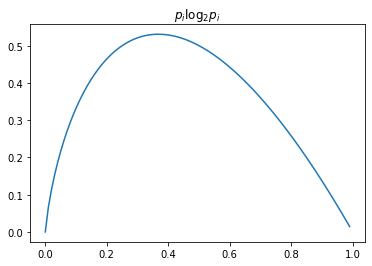

In [2]:
# graphing the entropy term for just one class
xs = [x / 100. for x in range(0, 100)]
ys = [-1 * p * (math.log(p, 2) if p > 0 else 0) for p in xs]
plt.plot(xs, ys)
plt.title("$p_i\log_2{p_i}$")
plt.show()

**Interesting:** Why is this not maximized at 0.5?

In [3]:
def entropy(class_probabilities: List[float]) -> float:
    """
    Given a list of the class sample probabilities for ALL known classes, computes the entropy of the overall dataset
    """
    return -1 * sum([p * (math.log(p, 2) if p > 0 else 0) for p in class_probabilities])

assert(entropy([0, 0]) == 0)
assert(entropy([]) == 0)
assert(entropy([1, 1]) == 0)
assert(entropy([.5, .5]) == 1)
assert(.81 < entropy([.25, .75]) < .82)

In [4]:
def class_probabilities(labels: List[Any]) -> List[float]:
    """
    Given a list of class labels in a data-set (raw list of all observed labels), compute class probabilities for each
    """
    counts: Counter = Counter(labels)
    total = len(labels)
    return [float(count) / total for count in counts.values()]

# order and connection to what the labels are is not preserved
assert(set(class_probabilities([1, 2, 3, 4, 1, 2, 2, 2])) == {.5, .25, .125, .125})
def dataset_entropy(labels: List[Any]) -> float:
    """
    composes class probabilities and entropy to get the entropy of the whole dataset
    """
    return entropy(class_probabilities(labels))

### Partition Entropy

Above, we have the tools to compute the entropy of an entire dataset. In building a decision tree, our goal will be to apply this to the partitions of a decision tree as defined by a particular question node. To do this, we'll compute a partition entropy: provided with a partition of a dataset (a list of lists), we'll compute the overall entropy of this partitioning as the entropy of each partition multiplied by the proportion of labels in that partition ($q_1H(S_1)1 + ... + q_mH(S_m) $):

$$ H = \sum_{i=1}^m q_i * H(S_i) $$



In [5]:
def partition_entropy(partitions: List[List[Any]]) -> float:
    """
    Given a partitioning of a dataset, compute the entropy of that partitioning as 
    the sum of the entropy of each partition multiplied by the proportion of labels it contains
    """
    total_count: int = sum(len(part) for part in partitions)
    return sum(dataset_entropy(part) * len(part) / total_count for part in partitions)

#### Over-fitting as a pitfall of minimizing entropy

Overall, we want to build a decision tree whicvh minimizes entropy in the leaves it generates. In fact, one of the most common algorithms for building an 'optimal' decision tree greedily chooses nodes that maxmize information gain, or the difference in entropy between the current partitioning and a future one. 

This leads to over-fitting, as a leaf node with only one training value has zero entropy. For features with a large variety of values this optimizes for a partitioning that creates few-example or single-example leaf nodes. If these differences don't generalize though, then the model is overfit.

### Making a Decision Tree

Putting this together for an algorithm which produces a decision tree, we want to do the following:

**Inputs:** A data set consisting of a list of discretely featured points and a discrete class label (this generalizes to real value features and real value labels, though).

**Outputs:** A tree which can be used to predict a class label from the features of the point

##### Algorithm
```
make_decision_tree(data):
    if (all data have the same label) 
        create a leaf node which predicts this label
        DONE
    if (there are no more possible features with which to differentiate the dataset)
        create a leaf node predicting the most common label
        DONE
    for EACH attribute:
        parts = partition the data on that attribute
        entropy = compute entropy of that partitioning
    create a decision node using the partitioning with the least entropy
    for EACH part:
        compute a sub-tree for each partitioning and attach it to this decision node
```

In [6]:
# My very cool data
class Animal(NamedTuple):
    """
    Everything important to know about animals
    """
    legs: int
    swims: bool
    claws: bool
    bites: bool
    colonizes: bool
    name: str

        
data = [
    Animal(2, True, False, True, True, 'human'),
    Animal(6, False, False, False, True, 'ant'),
    Animal(4, False, True, True, False, 'cat'),    
    Animal(4, True, True, True, False, 'dog'),    
    Animal(4, True, True, True, False, 'bear'),    
    Animal(4, False, False, True, False, 'horse'),    
    Animal(8, True, False, False, False, 'octopus'),    
    Animal(2, True, False, False, False, 'fish'),    
    Animal(6, True, False, False, False, 'squid'),    
    Animal(6, False, False, False, True, 'bee'),    
    Animal(6, False, False, False, False, 'butterfly'),    
    Animal(2, False, True, True, False, 'eagle'),    
    Animal(2, False, True, True, False, 'hawk'),    
    Animal(2, False, True, True, False, 'robin'),    
    Animal(2, False, True, True, False, 'crow'),    
]

# Joel's boring dubious data
class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None  # allow unlabeled data

                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

In [7]:
T = TypeVar('T')

In [8]:
def partition_by(points: List[T], attribute: str) -> Dict[Any, List[T]]:
    """
    Given a list of points, partition them by the attribute retrievable at <attribute>
    """   
    parts: Dict[Any, List[T]] = defaultdict(list)
    for p in points:
        key = getattr(p, attribute)
        parts[key].append(p)
    return parts


        

In [9]:
def partition_entropy_by(points: List[T], attribute: str, label_attribute: str) -> Tuple[Dict[Any, List[T]], float]:
    """
    Given a list of points, partition them by the attribute retrievable at <attribute> and compute the entropy of 
    each partition with respect to the attribute retrievable at <label_attribute>
    """
    parts: Dict[Any, List[T]] = partition_by(points, attribute)
        
    # partition_entropy requires us to process this data into just label buckets
    just_labels = []
    for key, vals in parts.items():
        just_labels.append([getattr(v, label_attribute) for v in vals])
    return parts, partition_entropy(just_labels)

assert 0.69 < partition_entropy_by(inputs, 'level', 'did_well')[1] < 0.70
assert 0.86 < partition_entropy_by(inputs, 'lang', 'did_well')[1] < 0.87
assert 0.78 < partition_entropy_by(inputs, 'tweets', 'did_well')[1] < 0.79
assert 0.89 < partition_entropy_by(inputs, 'phd', 'did_well')[1] < 0.90

In [11]:
# A tree will either be a leaf note, or a split
DecisionNode = Union['Leaf', 'Split']
class Leaf(NamedTuple): 
    value: Any
        
class Split(NamedTuple):
    attribute: str
    subtrees: Dict[Any, DecisionNode]
    default_value: Any = None
        


In [33]:
def classify(node: DecisionNode, input: Any):
    """
    Given a decision tree node and input to classify with that decision tree, 
    determine the appropriate label for the input
    """
    while(True):
        if isinstance(node, Leaf):
            return node.value
        else:
            # split: follow the right branch
            value = getattr(input, node.attribute)
            if value not in node.subtrees:
                return node.default_value
            # continue
            node = node.subtrees[value]

In [34]:
def build_tree_id3(data: List[Any], split_attributes: List[str], target_attribute: str) -> DecisionNode:
    """
    Given a dataset, a set of attributes belonging to the items in that dataset, and a target attribute, return
    the root node of a deicision tree which splits upon split_attributes, seeking to predict an inputs target
    attribute
    """
    counts = Counter([getattr(p, target_attribute) for p in data])
    most_common_target_attr = counts.most_common(1)[0][0]
    if len(counts) == 1:
        # everything has the same target attribute, just return a node with it
        return Leaf(most_common_target_attr)
    elif len(split_attributes) == 0:
        # nothing left to split on, just return the most common target attribute
        return Leaf(most_common_target_attr)
    parts_by_entropy: Dict[float, Tuple[str, Dict[Any, List[T]]]] = {}
    for attr in split_attributes:
        parts, entropy = partition_entropy_by(data, attr, target_attribute)
        # duplicate keys not an issue: if two share the lowest entropy we split on one arbitrarily
        parts_by_entropy[entropy] = (attr, parts)
    # find the partitioning with lowest entropy and create a Split with it
    attr, parts = parts_by_entropy[min(parts_by_entropy.keys())]
    subtrees: Dict[Any, DecisionNode] = {}
    for attr_val in parts:
        # recurse over sub-trees with one less split attribute
        subtrees[attr_val] = build_tree_id3(parts[attr_val], [a for a in split_attributes if a != attr], target_attribute)          
    return Split(attr, subtrees, most_common_target_attr)
        

In [35]:
# verify on Joels data
tree = build_tree_id3(inputs, ['level', 'lang', 'tweets', 'phd'], 'did_well')
print(json.dumps(tree, indent=1))
assert classify(tree, Candidate('Junior', 'Java', True, False))
assert not classify(tree, Candidate('Junior', 'Java', True, True))
# unexpected value happens to return true
assert classify(tree, Candidate('Intern', 'Java', True, False))

[
 "level",
 {
  "Senior": [
   "tweets",
   {
    "false": [
     false
    ],
    "true": [
     true
    ]
   },
   false
  ],
  "Mid": [
   true
  ],
  "Junior": [
   "phd",
   {
    "false": [
     true
    ],
    "true": [
     false
    ]
   },
   true
  ]
 },
 true
]


## Random Forests

Not surprisingly, decision trees as constructed above tend to significantly overfit. Several options for handling this:

1. Stoppage criteria [fixed depth or number of leaves (or something smarter)](https://courses.cs.washington.edu/courses/cse446/16sp/slides/week_1_2_decision_trees_Apr1.pdf)
2. Random forest: build several decision trees using the exact algorithm above but with bootstrapped data (sub-sets). This technique actually allows accurate performance assessment on the whole dataset if done carefully (no need for a test set).
3. Random forest 2: build several decision trees where at each split_attribute opportunity, you only consider some of the options.

In [50]:
RandomForest = List[DecisionNode]
def random_bootstrapped_forest(data: List[Any], split_attributes: List[str], target_attribute: str, n: int = 10, sampling_size: int = 0) -> RandomForest:
    """
    Train n decision trees using bootstrapped sub-samples of the input dataset
    """
    forest: RandomForest = []
    if sampling_size <= 0:
        sampling_size = len(data)
    for i in range(n):
        sub_sample: List[Any] = bootstrap_sample(data, sampling_size)
        forest.append(build_tree_id3(sub_sample, split_attributes, target_attribute))
    return forest

        
def random_forest_vote_classify(forest: RandomForest, x: Any) -> Any:
    """
    Classify using a random forest, using votes as the response mechanism
    """
    votes: List[Any] = []
    for tree in forest:
        votes.append(classify(tree, x))
    return Counter(votes).most_common(1)[0][0]
        
        
# verify on Joels data
forest: RandomForest = random_bootstrapped_forest(inputs, ['level', 'lang', 'tweets', 'phd'], 'did_well', n=200, sampling_size=0)
assert random_forest_vote_classify(forest, Candidate('Junior', 'R', True, False))
assert not random_forest_vote_classify(forest, Candidate('Junior', 'R', True, True))
# unexpected value happens to return true
assert random_forest_vote_classify(forest, Candidate('Intern', 'Java', True, False))
